In [1]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding


from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
%matplotlib inline

import pandas as pd
import numpy as np

import networkx as nx
from random import choice

In [20]:
G_train_nx = nx.read_edgelist('training.txt')
nodes_train = G_train_nx.nodes()
feature_vector = [1,1,1,1,1]
node_data = pd.DataFrame(
    [feature_vector for i in range(len(nodes_train))],
    index=[node for node in nodes_train])
G_train = sg.StellarGraph.from_networkx(G_train_nx, node_features=node_data)

In [21]:
G_test_nx = nx.read_edgelist('val_positive.txt')
nodes = G_test_nx.nodes()
feature_vector = [1,1,1,1,1]
node_data = pd.DataFrame(
    [feature_vector for i in range(len(nodes))],
    index=[node for node in nodes])
G_test = sg.StellarGraph.from_networkx(G_test_nx, node_features=node_data)

In [22]:
G_test_neg = nx.read_edgelist('val_negative.txt')
edges_test_neg = G_test_neg.edges()

In [23]:
edges_train_neg = []
i = 0
while i < len(nodes_train):
    node = choice(list(nodes_train))
    target = choice(list(nodes_train))
    if node != target and (node, target) not in G_train_nx.edges():
        edges_train_neg.append((node, target))
        i += 1

In [24]:
edge_ids_train = G_train.edges()
edge_labels_train = [1 for i in range(len(G_train.edges()))]
for neg_edge in edges_train_neg:
    edge_ids_train.append(neg_edge)
    edge_labels_train.append(0)
print(G_train.info())

StellarGraph: Undirected multigraph
 Nodes: 5240, Edges: 11496

 Node types:
  default: [5240]
    Features: float32 vector, length 5
    Edge types: default-default->default

 Edge types:
    default-default->default: [11496]
        Weights: all 1 (default)


In [25]:
edge_ids_test = G_test.edges()
edge_labels_test = [1 for i in range(len(G_test.edges()))]
for neg_edge in edges_test_neg:
    edge_ids_test.append(neg_edge)
    edge_labels_test.append(0)
print(G_test.info())

StellarGraph: Undirected multigraph
 Nodes: 186, Edges: 100

 Node types:
  default: [186]
    Features: float32 vector, length 5
    Edge types: default-default->default

 Edge types:
    default-default->default: [100]
        Weights: all 1 (default)


In [26]:
epochs = 50

In [27]:
train_gen = sg.mapper.FullBatchLinkGenerator(G_train, method="gcn")
train_flow = train_gen.flow(edge_ids_train, edge_labels_train)

Using GCN (local pooling) filters...


In [28]:
test_gen = FullBatchLinkGenerator(G_test, method="gcn")
test_flow = train_gen.flow(edge_ids_test, edge_labels_test)

Using GCN (local pooling) filters...


In [29]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=train_gen, dropout=0.3
)

In [30]:
x_inp, x_out = gcn.in_out_tensors()

In [31]:
prediction = LinkEmbedding(activation="relu", method="ip")(x_out)

In [32]:
prediction = keras.layers.Reshape((-1,))(prediction)

In [33]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=0.01),
    loss=keras.losses.binary_crossentropy,
    metrics=["accuracy"],
)

In [34]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 2ms/step - loss: 0.8400 - acc: 0.0000e+00

Train Set Metrics of the initial (untrained) model:
	loss: 0.6630
	acc: 0.0000

Test Set Metrics of the initial (untrained) model:
	loss: 0.8400
	acc: 0.0000


In [40]:
history = model.fit(
    train_flow, epochs=epochs, validation_data=test_flow, verbose=1, shuffle=False
)

Epoch 1/50
1/1 [==============================] - 0s 64ms/step - loss: 0.5990 - acc: 0.0000e+00 - val_loss: 1.0095 - val_acc: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 68ms/step - loss: 0.5765 - acc: 0.0000e+00 - val_loss: 0.8646 - val_acc: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 97ms/step - loss: 0.5842 - acc: 0.0000e+00 - val_loss: 0.8178 - val_acc: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 102ms/step - loss: 0.6052 - acc: 0.0000e+00 - val_loss: 0.8222 - val_acc: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 114ms/step - loss: 0.6092 - acc: 0.0000e+00 - val_loss: 0.8717 - val_acc: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 71ms/step - loss: 0.5961 - acc: 0.0000e+00 - val_loss: 0.9834 - val_acc: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 64ms/step - loss: 0.5770 - acc: 0.0000e+00 - val_loss: 1.1632 - val_acc: 0.0000e+00
Epoch 8/50
1/1 [=======================

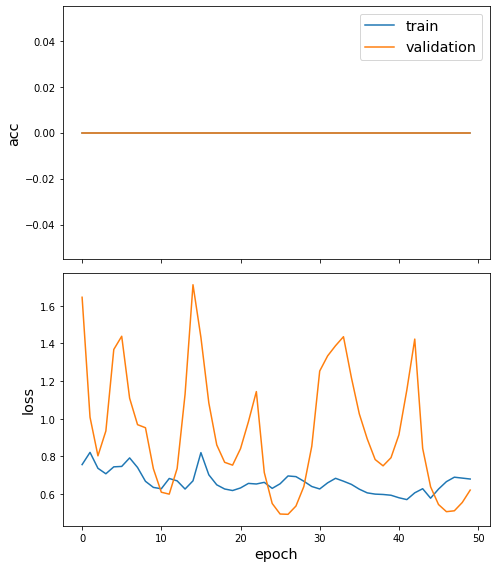

In [36]:
sg.utils.plot_history(history)

In [37]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 2ms/step - loss: 0.6215 - acc: 0.0000e+00

Train Set Metrics of the trained model:
	loss: 0.6926
	acc: 0.0000

Test Set Metrics of the trained model:
	loss: 0.6215
	acc: 0.0000
